1. какой длины серий бывают
2. как часто серии переворачиватся в плей-офф 
    - по раундам
3. самый сильный поворот
4. смоделировать исход этого сезона
5. был ли пример без поворотов
6. аналогично для подборов

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
import numpy as np
import pandas as pd
import tqdm
import glob
import os

pd.options.display.max_rows = 99
pd.options.display.max_columns = 60

from nba_api.stats.static import teams, players
import nba_api.stats.endpoints as endp
from nba_api.stats.endpoints import boxscoresummaryv2, leaguegamefinder,\
playbyplayv2, commonplayerinfo, commonallplayers
from nba_api.stats.library.parameters import Season, SeasonType, LeagueIDNullable, SeasonSegment
from nba_api.stats.library.eventmsgtype import EventMsgType
import nba_api.stats.library.playbyplayregex as prex

import altair as alt
from altair_saver import save as alt_save

import pandarallel
pandarallel.pandarallel.initialize(nb_workers=4)


pd.set_option('max_columns', 120)
pd.set_option('max_rows', 50)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# data

In [2]:
seasons = sorted(list(set([fpath[:7] for fpath in os.listdir('../seasons/')]))) # f'{s}-{str(s + 1)[-2:]}' for s in range(1991, 2021)]
print(len(seasons), seasons)

30 ['1991-92', '1992-93', '1993-94', '1994-95', '1995-96', '1996-97', '1997-98', '1998-99', '1999-00', '2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21']


In [3]:
df_rs = pd.concat([pd.read_csv(f'../seasons/{season}_Regular_Season.csv') for season in seasons],
                  axis=0)
df_rs['stage'] = 'rs'
df_po = pd.concat([pd.read_csv(f'../seasons/{season}_Playoffs.csv') for season in seasons],
                  axis=0)
df_po['stage'] = 'po'
print(df_rs.shape, df_po.shape)
df_rs.head(2)

(70026, 30) (4738, 30)


Unnamed: 0  SEASON_ID     TEAM_ID TEAM_ABBREVIATION            TEAM_NAME  \
0           0      21991  1610612760               SEA  Seattle SuperSonics   
1           1      21991  1610612737               ATL        Atlanta Hawks   

    GAME_ID   GAME_DATE    MATCHUP WL  MIN  PTS  FGM  FGA  FG_PCT  FG3M  FG3A  \
0  29101103  1992-04-19  SEA @ GOS  L  240  106   41   96   0.427     3    10   
1  29101100  1992-04-19  ATL @ CLE  L  240  108   45   85   0.529     4     8   

   FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST  STL  BLK  TOV  PF  \
0      0.3   21   29   0.724    25    27   52   21   18    6   20  28   
1      0.5   14   21   0.667     5    30   35   26   10    3   12  24   

   PLUS_MINUS stage  
0         NaN    rs  
1         NaN    rs

In [4]:
df_po.head(2)

Unnamed: 0  SEASON_ID     TEAM_ID TEAM_ABBREVIATION  \
0           0      41991  1610612757               POR   
1           1      41991  1610612741               CHI   

                TEAM_NAME   GAME_ID   GAME_DATE      MATCHUP WL  MIN  PTS  \
0  Portland Trail Blazers  49100073  1992-06-14    POR @ CHI  L  240   93   
1           Chicago Bulls  49100073  1992-06-14  CHI vs. POR  W  240   97   

   FGM  FGA  FG_PCT  FG3M  FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  \
0   35   78   0.449     2     7    0.286   21   21   1.000    13    25   38   
1   38   73   0.521     6    13    0.462   15   21   0.714     9    22   31   

   AST  STL  BLK  TOV  PF  PLUS_MINUS stage  
0   21   11    5   21  24         NaN    po  
1   20    8    5   18  19         NaN    po

In [5]:
def get_game_info(gr):
    _f = gr.TEAM_ABBREVIATION.min()
    _l = gr.TEAM_ABBREVIATION.max()
    _f_pts = gr.PTS[gr.TEAM_ABBREVIATION == _f].iloc[0]
    _l_pts = gr.PTS[gr.TEAM_ABBREVIATION == _l].iloc[0]
    result = {'season': str(gr.SEASON_ID.iloc[0])[-4:],
              'stage': gr.stage.iloc[0],
              'vs': f'{_f} - {_l}',
              't1': _f,
              't2': _l,
              'p1': _f_pts,
              'p2': _l_pts,
              'win': _f_pts > _l_pts}
    return pd.Series(result)
games_po = df_po.groupby('GAME_ID').parallel_apply(get_game_info)
games_rs = df_rs.groupby('GAME_ID').parallel_apply(get_game_info)
games_po.head()

season stage         vs   t1   t2   p1  p2    win
GAME_ID                                                   
40000001   2000    po  DAL - UTA  DAL  UTA   86  88  False
40000002   2000    po  MIN - SAS  MIN  SAS   82  87  False
40000003   2000    po  CHH - MIA  CHH  MIA  106  80   True
40000004   2000    po  IND - PHI  IND  PHI   79  78   True
40000005   2000    po  LAL - POR  LAL  POR  106  93   True

In [6]:
games = pd.concat([games_rs, games_po], axis=0)
print(games.shape)

(37382, 8)


In [7]:
def get_series_res(gr):
    s = gr.win
    w1 = s.sum()
    w2 = len(s) - w1
    result = {'w1': w1,
              'w2': w2,
              'games': w1 + w2,
              'series': f'{w1} - {w2}'}
    return pd.Series(result)
df = (games
 .groupby(['season', 'stage', 'vs'])
 .apply(get_series_res)
 .unstack(1)
 .swaplevel(-1, -2, axis=1)
 .sort_index(axis=1)
#  .dropna()
)
df.columns = ['_'.join(cols) for cols in df.columns]
df.reset_index(inplace=True)
print(df.shape)
df.head(2)

(12323, 10)


season         vs  po_games po_series  po_w1  po_w2  rs_games rs_series  \
0   1991  ATL - BOS       NaN       NaN    NaN    NaN       4.0     3 - 1   
1   1991  ATL - CHH       NaN       NaN    NaN    NaN       4.0     2 - 2   

   rs_w1  rs_w2  
0    3.0    1.0  
1    2.0    2.0

In [8]:
season_dict = {
 '1991': '27 команд',
 '1992': '27 команд',
 '1993': '27 команд',
 '1994': '27 команд',
 '1995': '29 команд',
 '1996': '29 команд',
 '1997': '29 команд',
 '1998': 'укороченный сезон',
 '1999': '29 команд',
 '2000': '29 команд',
 '2001': '29 команд',
 '2002': '29 команд',
 '2003': '29 команд',
 '2004': '30 команд',
 '2005': '30 команд',
 '2006': '30 команд',
 '2007': '30 команд',
 '2008': '30 команд',
 '2009': '30 команд',
 '2010': '30 команд',
 '2011': 'укороченный сезон',
 '2012': '30 команд',
 '2013': '30 команд',
 '2014': '30 команд',
 '2015': '30 команд',
 '2016': '30 команд',
 '2017': '30 команд',
 '2018': '30 команд',
 '2019': 'укороченный сезон',
 '2020': '30 команд'}

In [9]:
df['season_type'] = df.season.map(season_dict)

# series length

In [10]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

current play-off is excluded


2.0  3.0  4.0  5.0  6.0  7.0
po_games    1   26   97  125  117   82

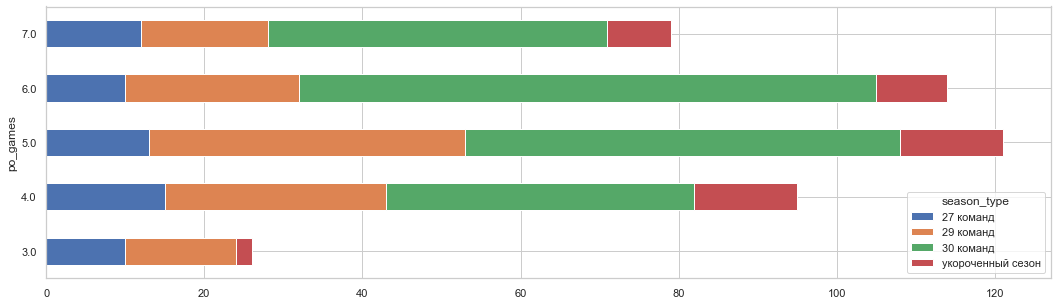

In [11]:
_, ax = plt.subplots(1,1, figsize=(18, 5))
tt = (df
      [df.season < '2020']
      .groupby(['season_type', 'po_games'])
      .vs.count()
      .unstack(0)
     )
tt.plot.barh(stacked=True, ax=ax)
print('current play-off is excluded')
df.po_games.value_counts().sort_index().to_frame().T

In [12]:
rr = df[df.season < '2020'].rename(columns={'po_games': 'series_len'})

In [13]:
def plot_series_len_bar(rr, y_title='Длина серии плей-офф'):  
    cc = alt.Chart(rr, height=300, width=800)

    bar = cc.mark_bar(width=15, height=40)
    bar = bar.encode(
        y=alt.Y('series_len', title=y_title,
                axis=alt.Axis(grid=False, tickCount=rr.series_len.nunique())), 
        x=alt.X('count()', title='Сколько было таких серий'), 
        color=alt.Color('season_type', title='Сезон'),
        order=alt.Order(
          # Sort the segments of the bars by this field
          'season_type',
          sort='ascending'
        )
    )

    return (bar
     .configure_legend(labelFontSize=15)
     .configure_axis(
            labelFontSize=15,
            titleFontSize=15
        )
    )
plot_series_len_bar(rr)

alt.Chart(...)

In [14]:
df.query('po_games <= 2')

season         vs  po_games po_series  po_w1  po_w2  rs_games rs_series  \
12180   2020  LAC - PHX       2.0     0 - 2    0.0    2.0       3.0     2 - 1   

       rs_w1  rs_w2 season_type  
12180    2.0    1.0   30 команд

1.0   2.0   3.0   4.0  5.0  6.0
rs_games  320  6026  1539  4173  252   12

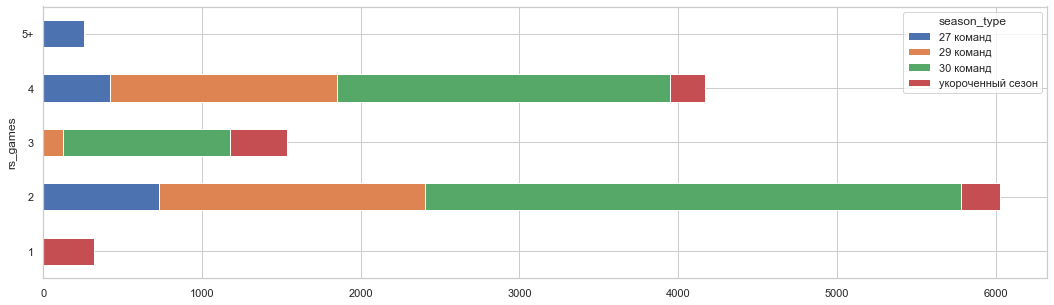

In [15]:
_, ax = plt.subplots(1,1, figsize=(18, 5))
tt = df.groupby(['season_type', df.rs_games.map(lambda c: str(int(c)) if c < 5 else '5+')]).vs.count().unstack(0)#.value_counts().sort_index()
tt.plot.barh(stacked=True, ax=ax)
df.rs_games.value_counts().sort_index().to_frame().T

In [16]:
rr = df.rename(columns={'rs_games': 'series_len'}).copy()
rr['series_len'] = rr.series_len.map(lambda c: str(int(c)) if c < 5 else '5+')

In [17]:
plot_series_len_bar(rr, y_title='Длина серии в регулярке')

alt.Chart(...)

In [18]:
df[df.rs_games == 1].season.value_counts().to_frame().sort_index().T

1998  2011  2019
season    84   180    56

In [19]:
df[df.rs_games >= 5].season.value_counts().to_frame().sort_index().T

1991  1992  1993  1994  1995  1996  1997  1999  2000  2001  2002  2003
season    64    64    64    64     1     1     1     1     1     1     1     1

In [20]:
df[((df.rs_games >= 5) & (df.season > '1994'))]

season         vs  po_games po_series  po_w1  po_w2  rs_games rs_series  \
1692   1995  MIA - NJN       NaN       NaN    NaN    NaN       5.0     5 - 0   
2151   1996  NYK - PHI       NaN       NaN    NaN    NaN       5.0     3 - 2   
2270   1997  BOS - WAS       NaN       NaN    NaN    NaN       5.0     3 - 2   
3232   1999  NJN - ORL       NaN       NaN    NaN    NaN       5.0     3 - 2   
3598   2000  MIA - NYK       NaN       NaN    NaN    NaN       5.0     2 - 3   
4092   2001  PHI - WAS       NaN       NaN    NaN    NaN       5.0     2 - 3   
4166   2002  BOS - ORL       NaN       NaN    NaN    NaN       5.0     3 - 2   
4815   2003  MIA - NJN       NaN       NaN    NaN    NaN       5.0     3 - 2   

      rs_w1  rs_w2 season_type  
1692    5.0    0.0   29 команд  
2151    3.0    2.0   29 команд  
2270    3.0    2.0   29 команд  
3232    3.0    2.0   29 команд  
3598    2.0    3.0   29 команд  
4092    2.0    3.0   29 команд  
4166    3.0    2.0   29 команд  
4815    3.0    2.0   29 команд

# turns

In [21]:
df[(
#     (df.po_games.isna() & df.rs_games.notna())
#     |
    (df.rs_games.isna() & df.po_games.notna())
)]

season         vs  po_games po_series  po_w1  po_w2  rs_games rs_series  \
2860   1998  NYK - SAS       5.0     1 - 4    1.0    4.0       NaN       NaN   

      rs_w1  rs_w2        season_type  
2860    NaN    NaN  укороченный сезон

In [22]:
df_t = df.query('season < "2020"').dropna().copy()
df_t['vs'] = df_t.vs.str.replace('GOS', 'GSW')
print(df_t.shape)
df_t.head(2)

(434, 11)


season         vs  po_games po_series  po_w1  po_w2  rs_games rs_series  \
28   1991  BOS - CLE       7.0     3 - 4    3.0    4.0       4.0     3 - 1   
34   1991  BOS - IND       3.0     3 - 0    3.0    0.0       4.0     2 - 2   

    rs_w1  rs_w2 season_type  
28    3.0    1.0   27 команд  
34    2.0    2.0   27 команд

In [23]:
for stage in ['po', 'rs']:
    df_t[f'{stage}_dif'] = df_t[f'{stage}_w1'] - df_t[f'{stage}_w2']

def get_turn(r):
    rs_dif = r.rs_dif
    po_dif = r.po_dif
    if rs_dif == 0:
        return 'tied'
    if rs_dif * po_dif > 0:
        return 'no_turn'
    else:
        return 'turn'

df_t['turn'] = df_t.apply(get_turn, axis=1)
df_t.head(2)

season         vs  po_games po_series  po_w1  po_w2  rs_games rs_series  \
28   1991  BOS - CLE       7.0     3 - 4    3.0    4.0       4.0     3 - 1   
34   1991  BOS - IND       3.0     3 - 0    3.0    0.0       4.0     2 - 2   

    rs_w1  rs_w2 season_type  po_dif  rs_dif  turn  
28    3.0    1.0   27 команд    -1.0     2.0  turn  
34    2.0    2.0   27 команд     3.0     0.0  tied

In [24]:
(df_t.query('turn != "tied"').turn == 'turn').mean()

0.310126582278481

## by play-off round

In [25]:
po = pd.read_csv('playoffs.csv').dropna(axis=0, subset=['Yr'])
po = po[po.Yr != 'Yr'].copy()
po['Yr'] = po.Yr.map(lambda s: str(int(s) - 1))
print(po.shape)
po.head(2)

(435, 13)


Yr   Lg                    Series                          .1  \
0  2019  NBA  Eastern Conf First Round  Aug 18 - Aug 29, 2020  NaN   
1  2019  NBA  Eastern Conf First Round  Aug 17 - Aug 23, 2020  NaN   

                  Team    W   .2             Team.1  W.1   .3     Favorite  \
0  Milwaukee Bucks (1)  NaN  NaN  Orlando Magic (8)  NaN  NaN  MIL (-7500)   
1  Toronto Raptors (2)  NaN  NaN  Brooklyn Nets (7)  NaN  NaN  TOR (-2200)   

      Underdog  
0  ORL (+3250)  
1  BRK (+1315)

In [26]:
po.Yr.value_counts(dropna=False).sort_index().to_frame().T

1991  1992  1993  1994  1995  1996  1997  1998  1999  2000  2001  2002  \
Yr    15    15    15    15    15    15    15    15    15    15    15    15   

    2003  2004  2005  2006  2007  2008  2009  2010  2011  2012  2013  2014  \
Yr    15    15    15    15    15    15    15    15    15    15    15    15   

    2015  2016  2017  2018  2019  
Yr    15    15    15    15    15

In [27]:
round_dict = {
 'Western Conf First Round': '1ый раунд',
 'Eastern Conf First Round': '1ый раунд',
 'Western Conf Semifinals': '2ой раунд',
 'Eastern Conf Semifinals': '2ой раунд',
 'Finals': 'Финал',
 'Eastern Conf Finals': 'Полуфинал',
 'Western Conf Finals': 'Полуфинал'}
po['Round'] = po.Series.map(round_dict)
po.Round.value_counts(dropna=False).sort_index().to_frame().T

1ый раунд  2ой раунд  Полуфинал  Финал
Round        232        116         58     29

In [28]:
def get_vs(r):
    replaces = [('WSB', 'WAS'),
                ('BRK', 'BKN'),
                ('CHH', 'CHA')]
    vals = [r.Favorite[:3], r.Underdog[:3]]
    for p, r in replaces:
        vals = [v.replace(p, r) for v in vals]
    return ' - '.join(sorted(vals))
po['vs'] = po.apply(get_vs, axis=1)

year_vs2round_dict = {(y, vs): r for y, vs, r in zip(po.Yr, po.vs, po.Round)}

pairs = [('GOS', 'GSW'),
         ('UTH', 'UTA'),
         ('PHX', 'PHO'),
         ('SAN', 'SAS'),
         ('WSB', 'WAS'),
         ('CHH', 'CHA')]
for p, r in pairs:
    df_t['vs'] = df_t.vs.str.replace(p, r)
print(df_t.shape)
df_t.head(2)

df_t['po_round'] = df_t.apply(lambda r: year_vs2round_dict[(r.season, r.vs)], axis=1)
df_t.po_round.value_counts(dropna=False).sort_index().to_frame().T

(434, 14)


1ый раунд  2ой раунд  Полуфинал  Финал
po_round        232        116         58     28

In [29]:
def calc_prob(gr):
    no_tie = gr.query('turn != "tied"')
    prob = (no_tie.turn == 'turn').mean()
    cnt = len(no_tie)
    turn_cnt = (no_tie.turn == 'turn').sum()
    noturn_cnt = (no_tie.turn != 'turn').sum()
    return pd.Series({'no_tie_count': cnt,
                      'tie_count': len(gr) - cnt,
                      'turn_count': turn_cnt,
                      'noturn_count': noturn_cnt,
                      'turn_ratio': prob})
calc_prob(df_t)

no_tie_count    316.000000
tie_count       118.000000
turn_count       98.000000
noturn_count    218.000000
turn_ratio        0.310127
dtype: float64

In [30]:
by_round = df_t.groupby('po_round').apply(calc_prob)
by_round

no_tie_count  tie_count  turn_count  noturn_count  turn_ratio
po_round                                                                
1ый раунд         169.0       63.0        40.0         129.0    0.236686
2ой раунд          92.0       24.0        29.0          63.0    0.315217
Полуфинал          41.0       17.0        23.0          18.0    0.560976
Финал              14.0       14.0         6.0           8.0    0.428571

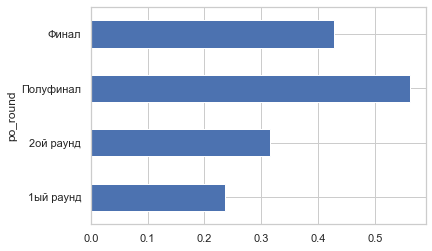

In [31]:
by_round.turn_ratio.plot.barh()

In [32]:
cc = alt.Chart(by_round.reset_index(), height=300, width=500)

bar = cc.mark_tick(thickness=7, width=100)
bar = bar.encode(
    x=alt.X('po_round', title='Раунд плей-офф',
            axis=alt.Axis(grid=False, labelAngle=0)
           ), 
    y=alt.Y('turn_ratio', title='Доля серий с переворотом'), 
    color=alt.Color('no_tie_count', title='Серий без ничьих в регулярке')
)

txt = alt.Chart(by_round.reset_index()).mark_text(dx=-0, dy=-10, color='black').encode(
    x=alt.X('po_round', stack='zero'),
    y=alt.Y('turn_ratio'),
#     detail='site:N',
    text=alt.Text('turn_ratio', format='.1%')
)


((bar + txt)
 .configure_legend(labelFontSize=15)
 .configure_axis(
        labelFontSize=15,
        titleFontSize=15
    )
)

alt.LayerChart(...)

## biggest turn

In [33]:
df_t['po_rs_dif'] = (df_t.po_dif - df_t.rs_dif).abs()
df_t.sort_values('po_rs_dif').tail(10)

season         vs  po_games po_series  po_w1  po_w2  rs_games rs_series  \
4808    2003  MEM - SAS       4.0     0 - 4    0.0    4.0       4.0     3 - 1   
2217    1997  ATL - CHA       4.0     1 - 3    1.0    3.0       4.0     4 - 0   
1259    1994  HOU - ORL       4.0     4 - 0    4.0    0.0       2.0     0 - 2   
1264    1994  HOU - SAS       6.0     4 - 2    4.0    2.0       6.0     1 - 5   
2499    1997  LAL - UTA       4.0     0 - 4    0.0    4.0       4.0     3 - 1   
9287    2014  ATL - CLE       4.0     0 - 4    0.0    4.0       4.0     3 - 1   
11533   2019  BOS - PHI       4.0     4 - 0    4.0    0.0       4.0     1 - 3   
9716    2014  TOR - WAS       4.0     0 - 4    0.0    4.0       3.0     3 - 0   
8890    2013  BKN - MIA       5.0     1 - 4    1.0    4.0       4.0     4 - 0   
11416   2018  OKC - POR       5.0     1 - 4    1.0    4.0       4.0     4 - 0   

       rs_w1  rs_w2        season_type  po_dif  rs_dif  turn   po_round  \
4808     3.0    1.0          29 команд    -4.0     2.0  turn  1ый раунд   
2217     4.0    0.0          29 команд    -2.0     4.0  turn  1ый раунд   
1259     0.0    2.0          27 команд     4.0    -2.0  turn      Финал   
1264     1.0    5.0          27 команд     2.0    -4.0  turn  Полуфинал   
2499     3.0    1.0          29 команд    -4.0     2.0  turn  Полуфинал   
9287     3.0    1.0          30 команд    -4.0     2.0  turn  Полуфинал   
11533    1.0    3.0  укороченный сезон     4.0    -2.0  turn  1ый раунд   
9716     3.0    0.0          30 команд    -4.0     3.0  turn  1ый раунд   
8890     4.0    0.0          30 команд    -3.0     4.0  turn  2ой раунд   
11416    4.0    0.0          30 команд    -3.0     4.0  turn  1ый раунд   

       po_rs_dif  
4808         6.0  
2217         6.0  
1259         6.0  
1264         6.0  
2499         6.0  
9287         6.0  
11533        6.0  
9716         7.0  
8890         7.0  
11416        7.0

## year with minimum and maximum turns

In [34]:
by_year = df_t.groupby('season').apply(calc_prob).sort_values('turn_ratio')
by_year

no_tie_count  tie_count  turn_count  noturn_count  turn_ratio
season                                                               
2004             9.0        6.0         0.0           9.0    0.000000
2008            12.0        3.0         1.0          11.0    0.083333
2007             8.0        7.0         1.0           7.0    0.125000
2016            11.0        4.0         2.0           9.0    0.181818
2014            11.0        4.0         2.0           9.0    0.181818
2000             9.0        6.0         2.0           7.0    0.222222
1995            13.0        2.0         3.0          10.0    0.230769
2006            12.0        3.0         3.0           9.0    0.250000
2017            11.0        4.0         3.0           8.0    0.272727
1993            11.0        4.0         3.0           8.0    0.272727
2012            10.0        5.0         3.0           7.0    0.300000
2001            10.0        5.0         3.0           7.0    0.300000
2015            13.0        2.0         4.0           9.0    0.307692
2010            13.0        2.0         4.0           9.0    0.307692
2019            15.0        0.0         5.0          10.0    0.333333
1994            12.0        3.0         4.0           8.0    0.333333
2003            12.0        3.0         4.0           8.0    0.333333
2009            12.0        3.0         4.0           8.0    0.333333
2011            14.0        1.0         5.0           9.0    0.357143
1991            11.0        4.0         4.0           7.0    0.363636
2013             8.0        7.0         3.0           5.0    0.375000
1996            10.0        5.0         4.0           6.0    0.400000
1992            10.0        5.0         4.0           6.0    0.400000
2018            10.0        5.0         4.0           6.0    0.400000
2005            12.0        3.0         5.0           7.0    0.416667
1997            11.0        4.0         5.0           6.0    0.454545
2002             8.0        7.0         4.0           4.0    0.500000
1999             6.0        9.0         3.0           3.0    0.500000
1998            12.0        2.0         6.0           6.0    0.500000

# 2020-21 playoff

In [35]:
df[df.season == '2020'].dropna()

season         vs  po_games po_series  po_w1  po_w2  rs_games rs_series  \
11906   2020  ATL - NYK       5.0     4 - 1    4.0    1.0       3.0     0 - 3   
11909   2020  ATL - PHI       7.0     4 - 3    4.0    3.0       3.0     1 - 2   
11917   2020  BKN - BOS       5.0     4 - 1    4.0    1.0       3.0     3 - 0   
11931   2020  BKN - MIL       7.0     3 - 4    3.0    4.0       3.0     1 - 2   
12052   2020  DAL - LAC       7.0     3 - 4    3.0    4.0       3.0     2 - 1   
12085   2020  DEN - PHX       4.0     0 - 4    0.0    4.0       3.0     2 - 1   
12086   2020  DEN - POR       6.0     4 - 2    4.0    2.0       3.0     2 - 1   
12180   2020  LAC - PHX       2.0     0 - 2    0.0    2.0       3.0     2 - 1   
12185   2020  LAC - UTA       6.0     4 - 2    4.0    2.0       3.0     1 - 2   
12196   2020  LAL - PHX       6.0     2 - 4    2.0    4.0       3.0     1 - 2   
12216   2020  MEM - UTA       5.0     1 - 4    1.0    4.0       3.0     0 - 3   
12218   2020  MIA - MIL       4.0     0 - 4    0.0    4.0       3.0     1 - 2   
12301   2020  PHI - WAS       5.0     4 - 1    4.0    1.0       3.0     3 - 0   

       rs_w1  rs_w2 season_type  
11906    0.0    3.0   30 команд  
11909    1.0    2.0   30 команд  
11917    3.0    0.0   30 команд  
11931    1.0    2.0   30 команд  
12052    2.0    1.0   30 команд  
12085    2.0    1.0   30 команд  
12086    2.0    1.0   30 команд  
12180    2.0    1.0   30 команд  
12185    1.0    2.0   30 команд  
12196    1.0    2.0   30 команд  
12216    0.0    3.0   30 команд  
12218    1.0    2.0   30 команд  
12301    3.0    0.0   30 команд

In [36]:
df[((df.season == '2020')
    & (df.vs.isin(['ATL - MIL', 'LAC - PHX', 
               'ATL - PHX', 'MIL - PHX', 
               'ATL - LAC', 'LAC - MIL']))
   )]

season         vs  po_games po_series  po_w1  po_w2  rs_games rs_series  \
11899   2020  ATL - LAC       NaN       NaN    NaN    NaN       2.0     1 - 1   
11903   2020  ATL - MIL       NaN       NaN    NaN    NaN       3.0     1 - 2   
11910   2020  ATL - PHX       NaN       NaN    NaN    NaN       2.0     1 - 1   
12173   2020  LAC - MIL       NaN       NaN    NaN    NaN       2.0     1 - 1   
12180   2020  LAC - PHX       2.0     0 - 2    0.0    2.0       3.0     2 - 1   
12238   2020  MIL - PHX       NaN       NaN    NaN    NaN       2.0     0 - 2   

       rs_w1  rs_w2 season_type  
11899    1.0    1.0   30 команд  
11903    1.0    2.0   30 команд  
11910    1.0    1.0   30 команд  
12173    1.0    1.0   30 команд  
12180    2.0    1.0   30 команд  
12238    0.0    2.0   30 команд